## Notebook for NaI Array Calibration
Alya Sharbaugh, Anthony Villano, University of Colorado Denver

In [1]:
# Import libraries

import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel,LinearModel

#import hist
#from hist import Hist
#from tabulate import tabulate


### Functions for Plots and Fits

In [2]:
# Define Gaussian distribution function

def Gauss(x, a, x0, sigma): 
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) 


In [3]:
# Define function for plotting histograms

def PlotHist(name,data,bins):

    fig, ax = plt.subplots(figsize=(8, 5))
    title = "Detector " + name[3:5]

    ax.plot(bins,data)
    
    ax.set_title(title)
    ax.set_xlabel("ADC Channel")
    ax.set_ylabel("PDF")
    ax.set_xlim([0,450])
    
    plt.show()
    

In [4]:
# Define function for plotting histograms with fit

def PlotFit(name,bins,data,bins1,fit1,bins2,fit2):

    fig, ax = plt.subplots(figsize=(8, 5))
    title = "Detector " + name[3:5]

    ax.plot(bins,data)
    ax.plot(bins1,fit1,'g--',label='Peak Fit')
    ax.plot(bins2,fit2,'r--',label='Peak Fit')

    ax.set_title(title)
    ax.set_xlabel("ADC Channel")
    ax.set_ylabel("PDF")
    ax.set_xlim([0,450])
    ax.legend(loc=1,prop={'size':12})
    
    plt.show()
    

### Background Calibration

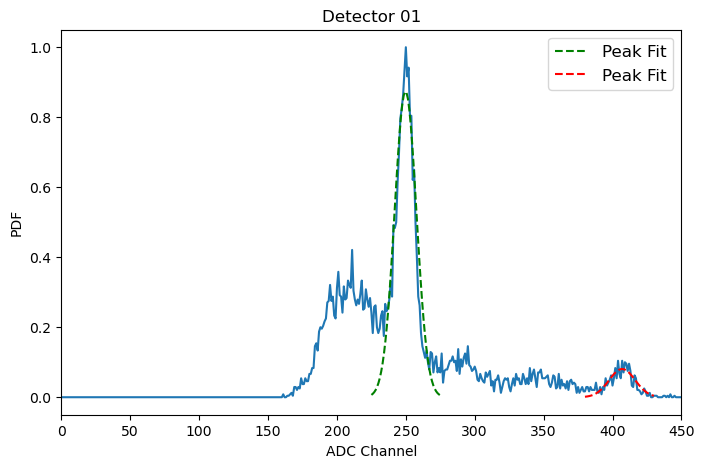

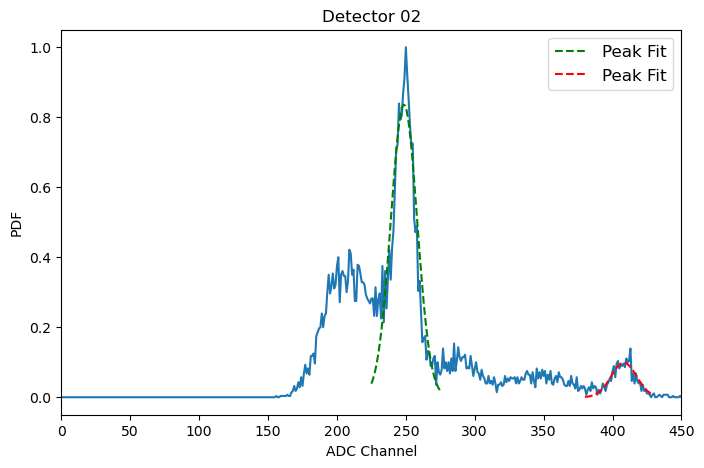

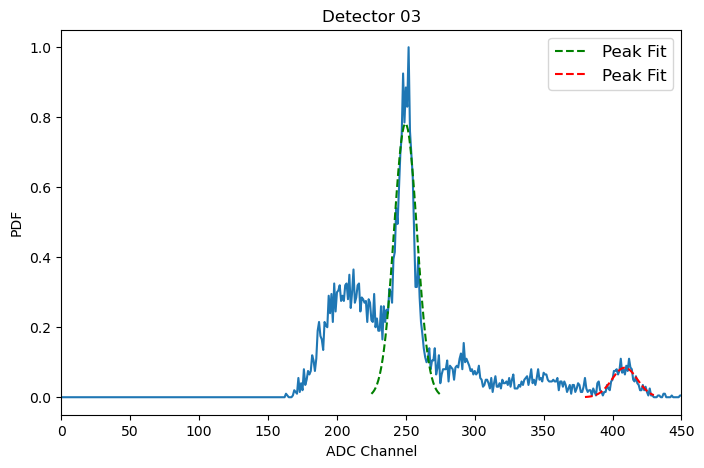

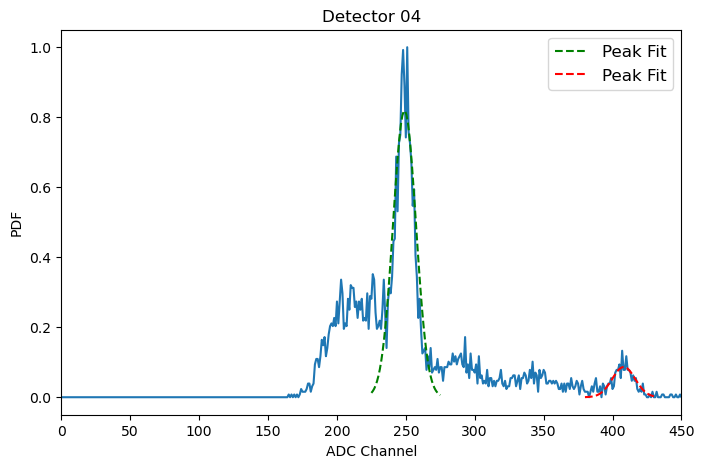

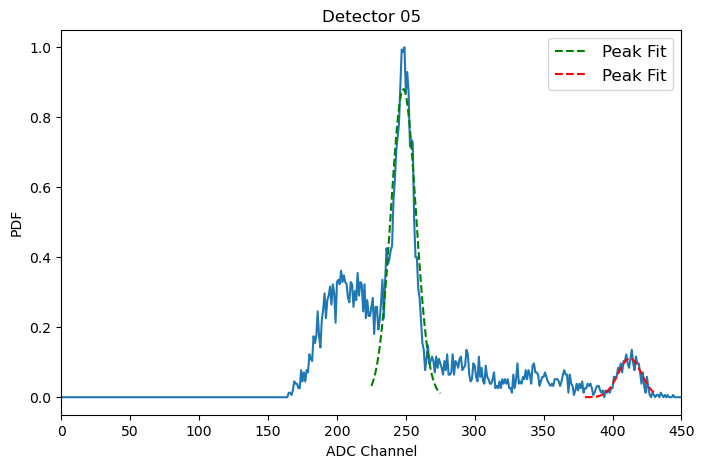

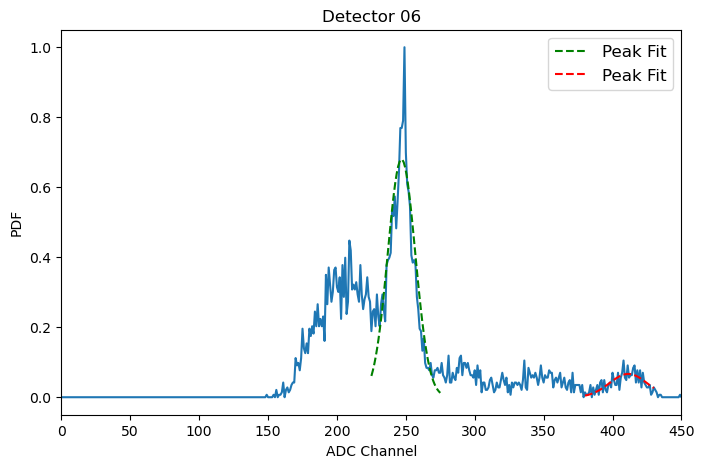

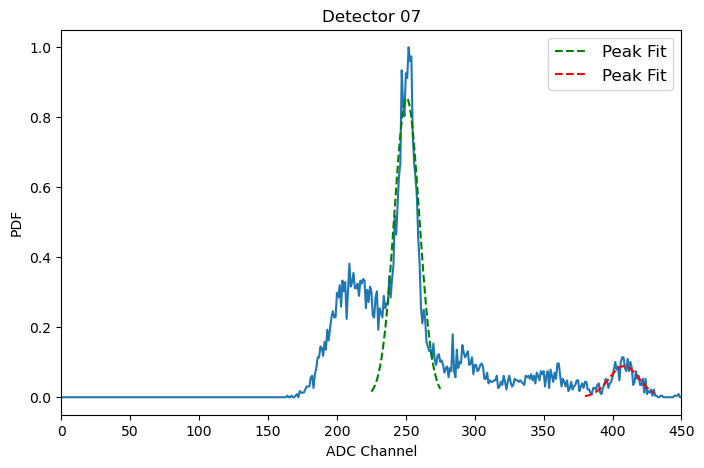

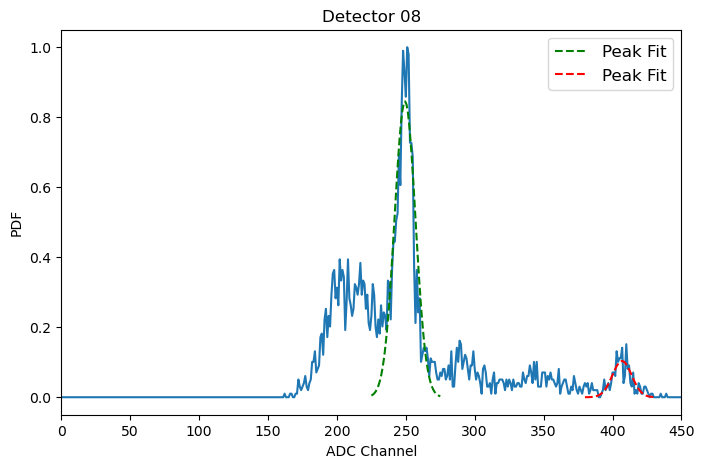

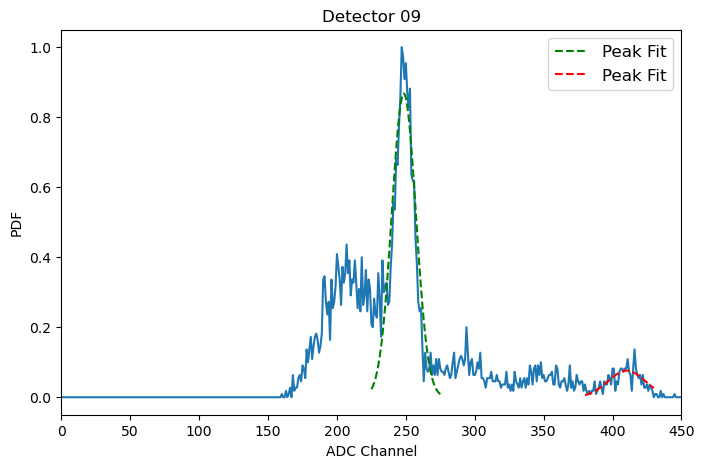

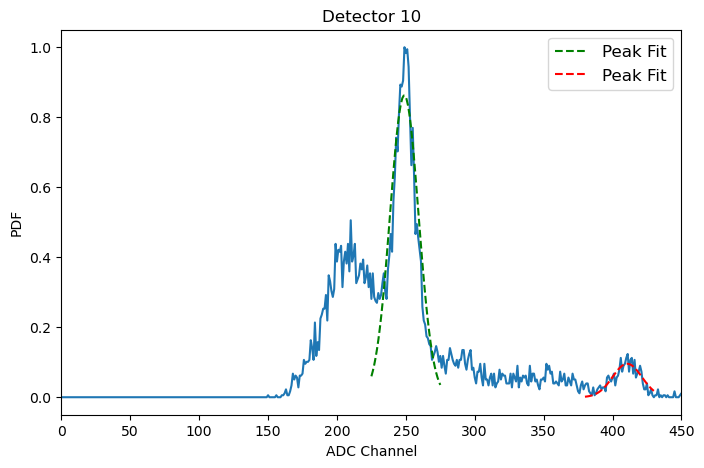

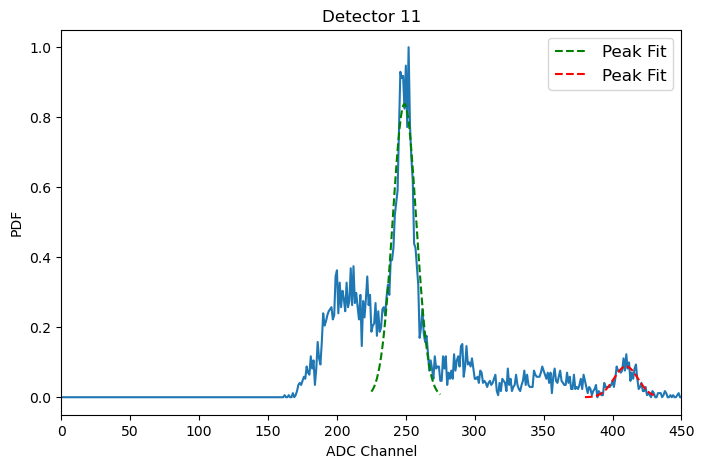

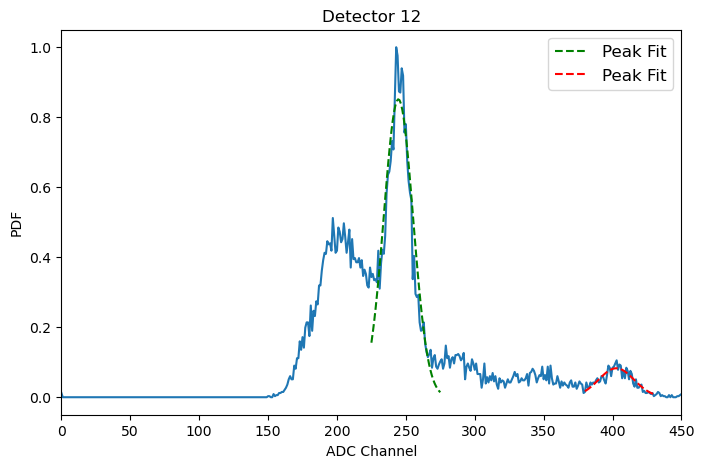

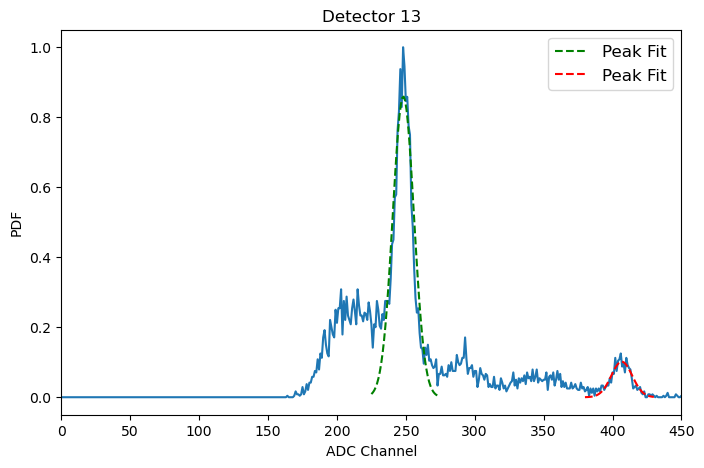

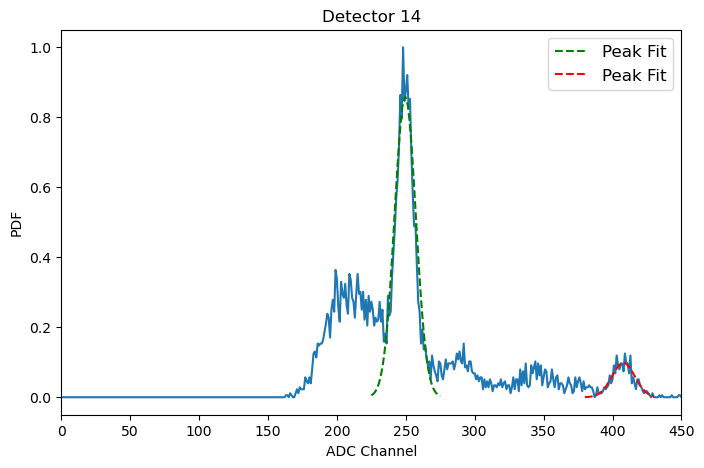

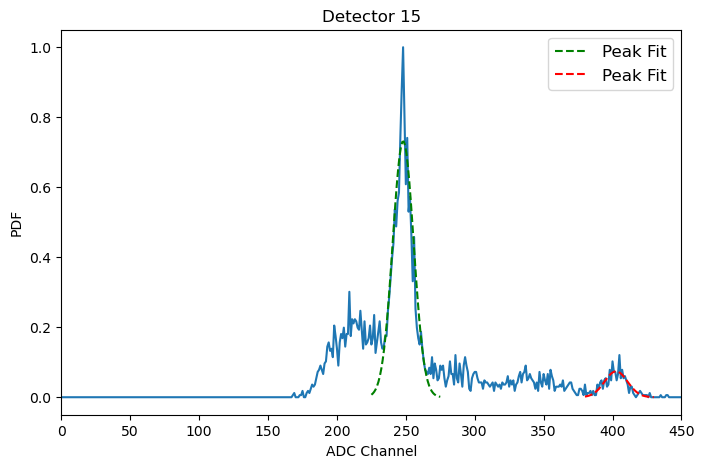

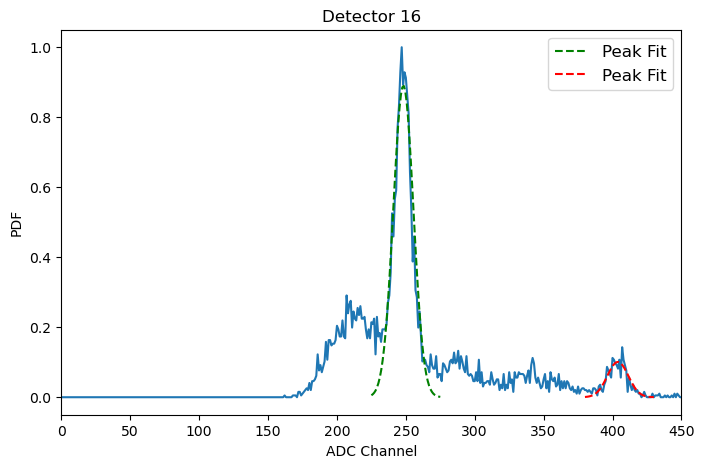

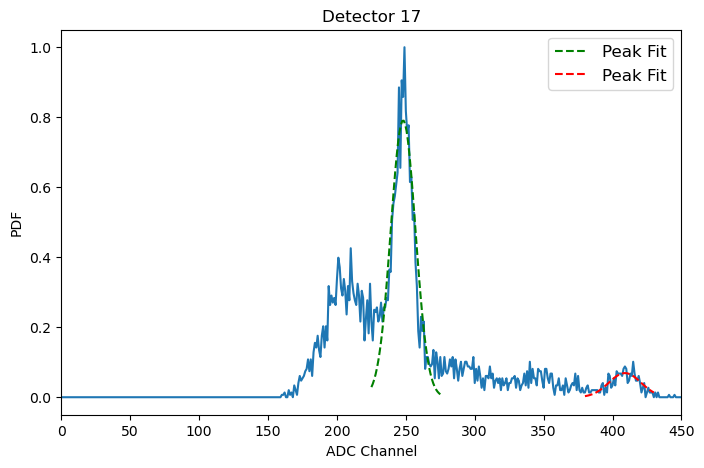

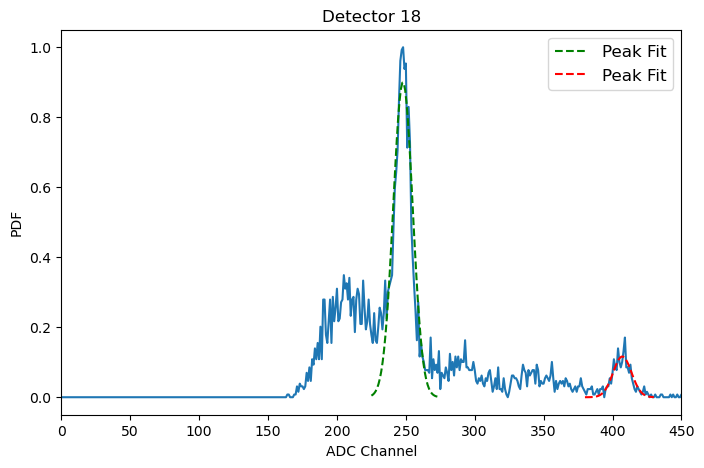

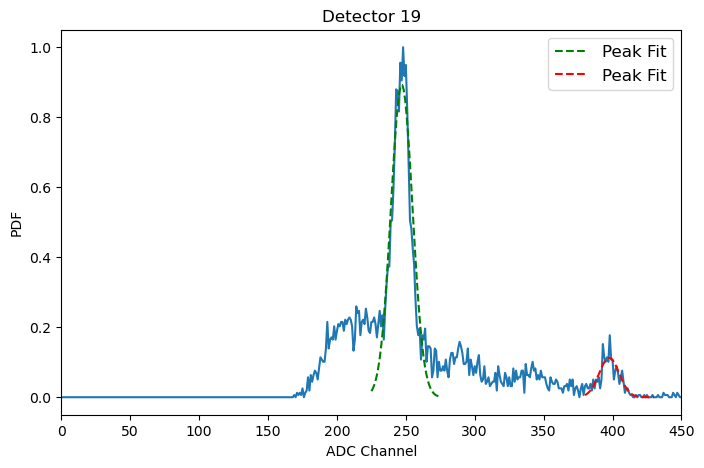

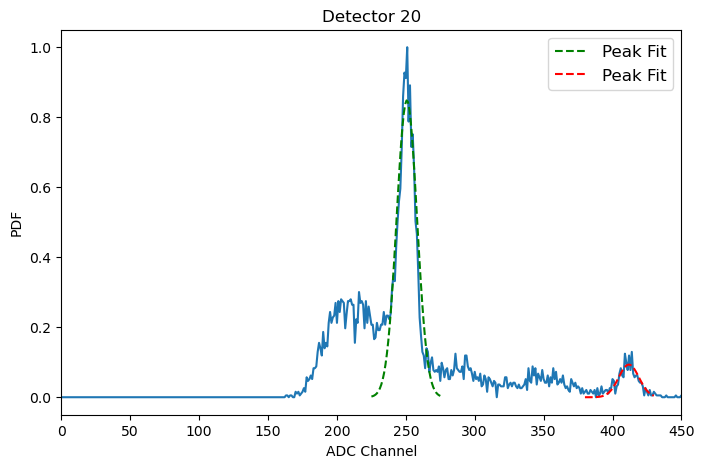

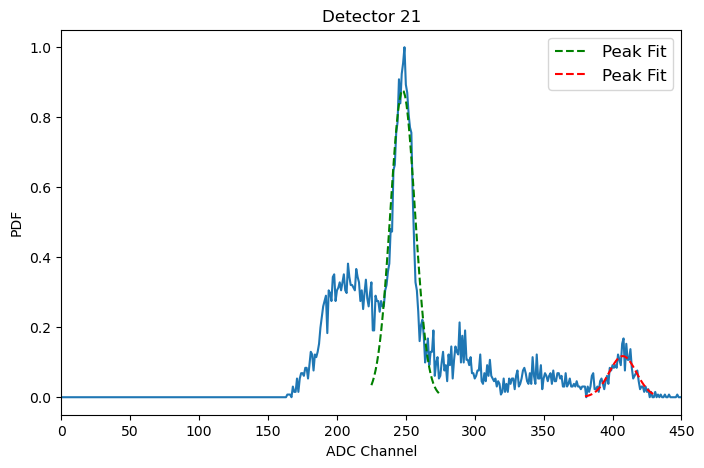

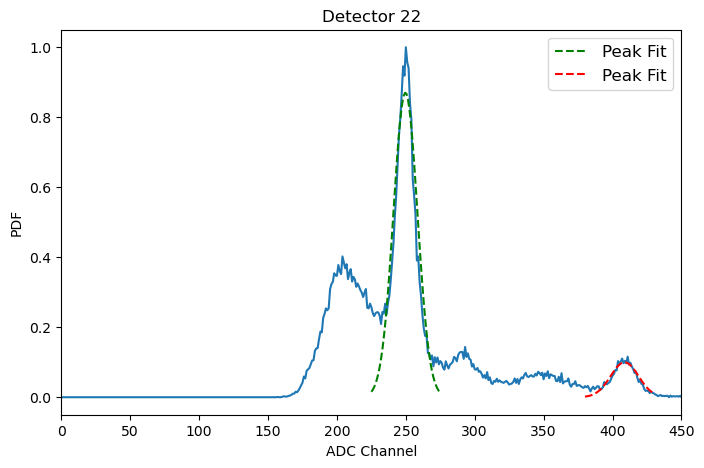

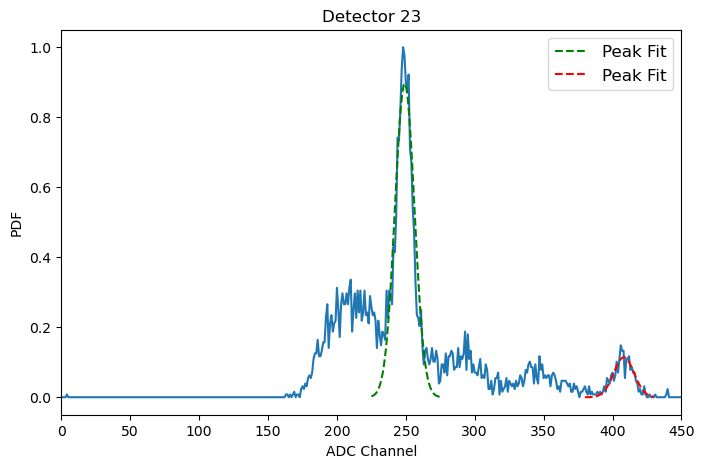

In [5]:
# Read in data from ROOT files and plot

directory = os.fsencode("Bknd_Calibration")
    
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    datafile = "Bknd_Calibration/" + filename
    
    with uproot.open(datafile) as file:

        #print(file.keys())
        bknd = file["Energy/_F_EnergyCH0@DT5751_626"]
        bkndData,bins = bknd.to_numpy()

        bins = bins[:-1]   # Needed to trim bins to make arrays the same size, not sure why?
        
        bkndNorm = (bkndData - bkndData.min())/ (bkndData.max() - bkndData.min())   # Normalize since inconsistent counts

        #PlotHist(filename,bkndNorm,bins)

        bins1 = np.linspace(225,275,50)
        bins2 = np.linspace(380,430,50)

        ##################################
        #        SCIPY FITTING
        ##################################

        popt1, pcov1 = curve_fit(Gauss,bins1,bkndNorm[225:275],p0=[1,250,6])
        popt2, pcov2 = curve_fit(Gauss,bins2,bkndNorm[380:430],p0=[0.1,415,8])

        bestFit1 = Gauss(bins1,popt1[0],popt1[1],popt1[2])
        bestFit2 = Gauss(bins2,popt2[0],popt2[1],popt2[2])

        ##################################
        #        PLOT THE FIT
        ##################################

        PlotFit(filename,bins,bkndNorm,bins1,bestFit1,bins2,bestFit2)   # Plot normalized curve with fits
    

### Na-22 Calibration

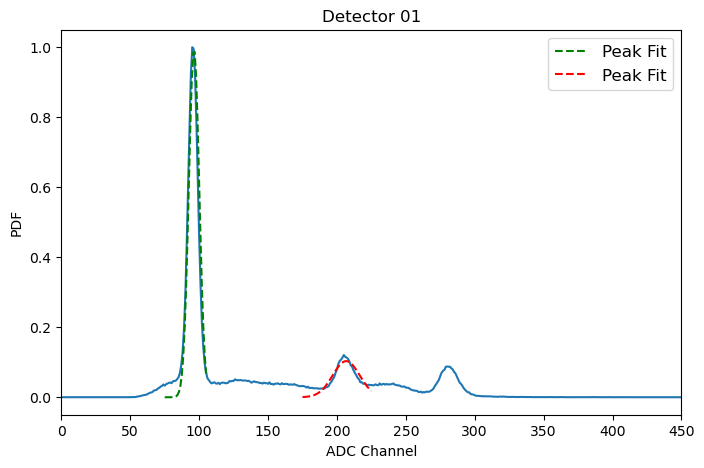

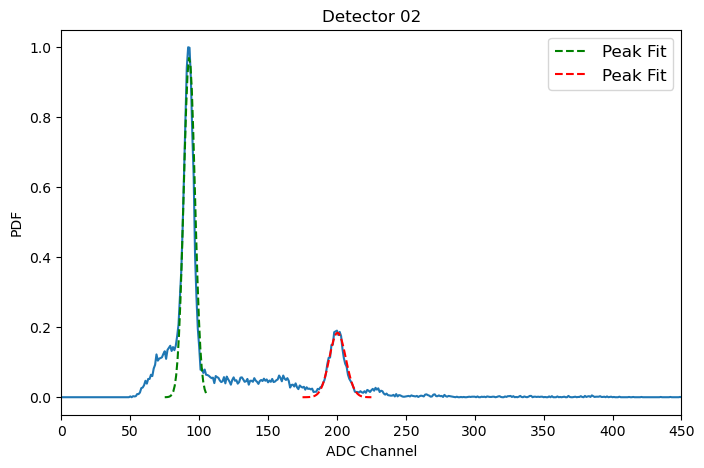

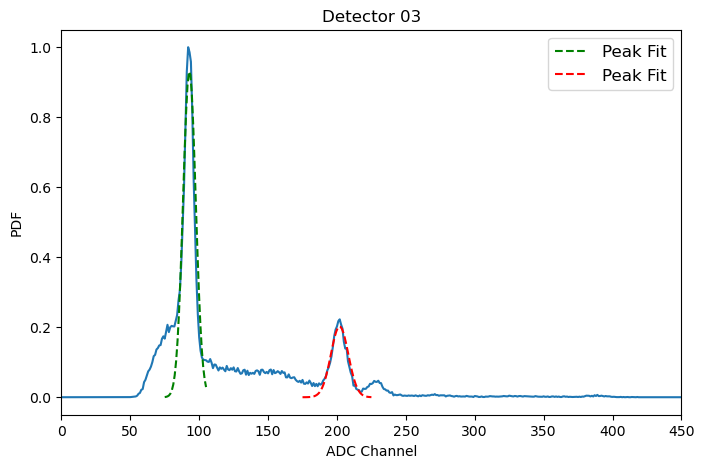

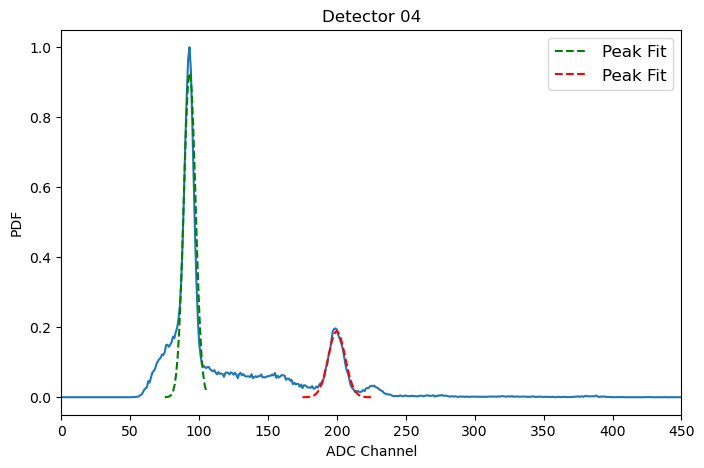

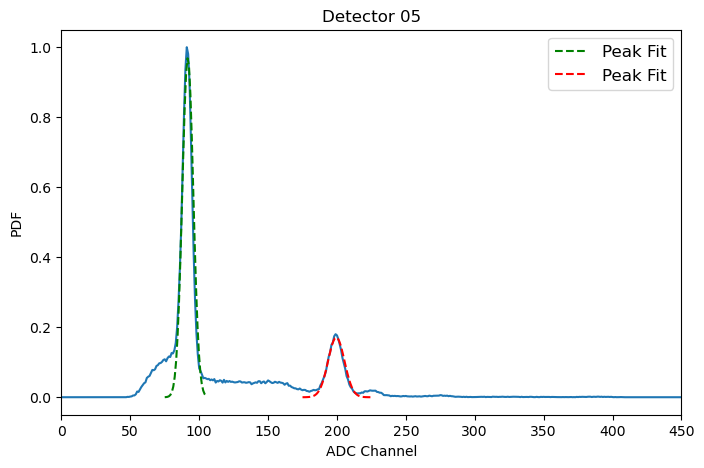

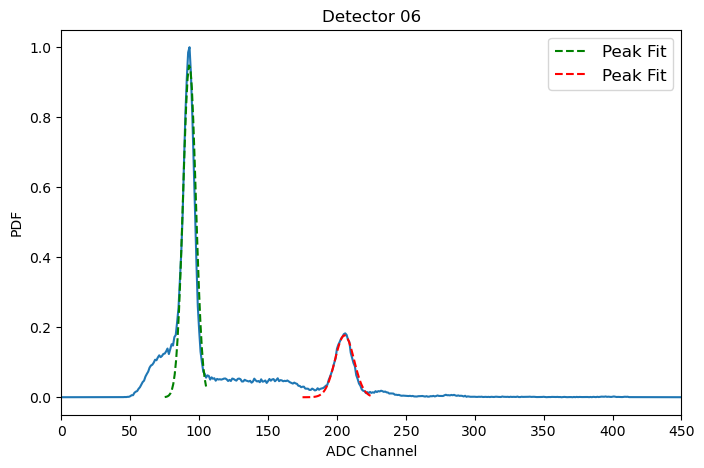

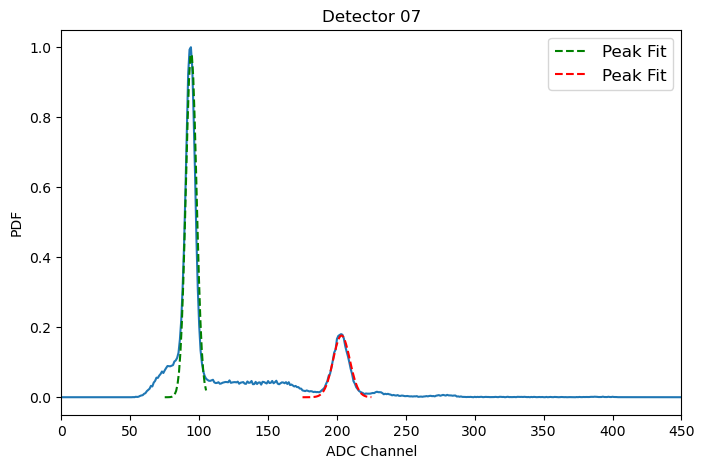

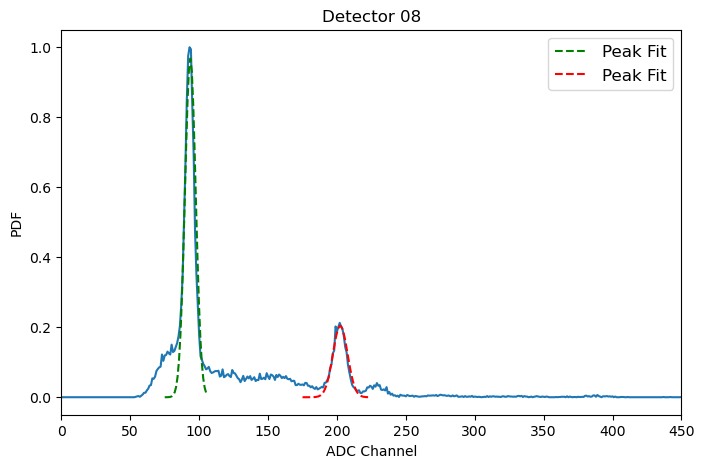

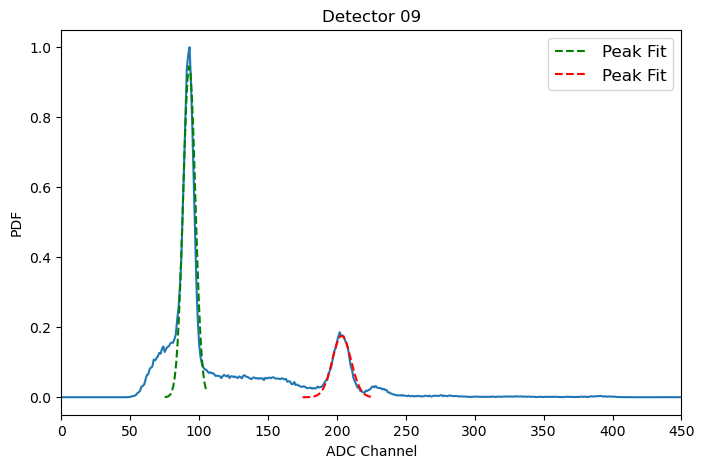

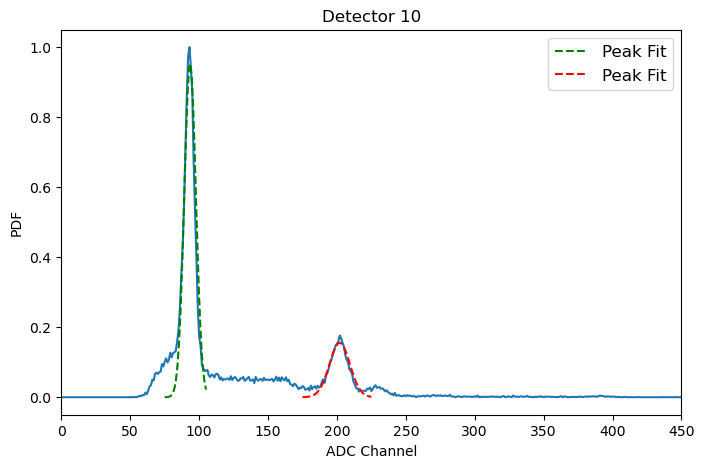

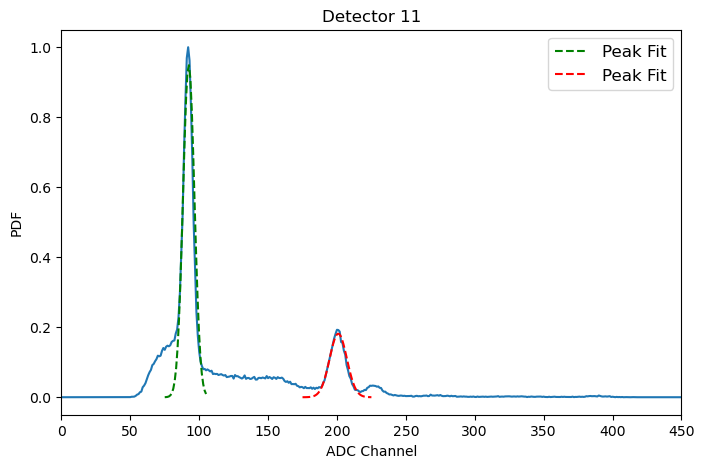

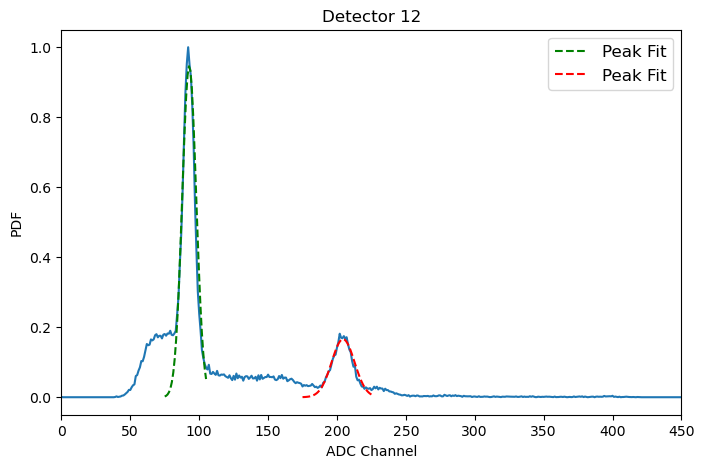

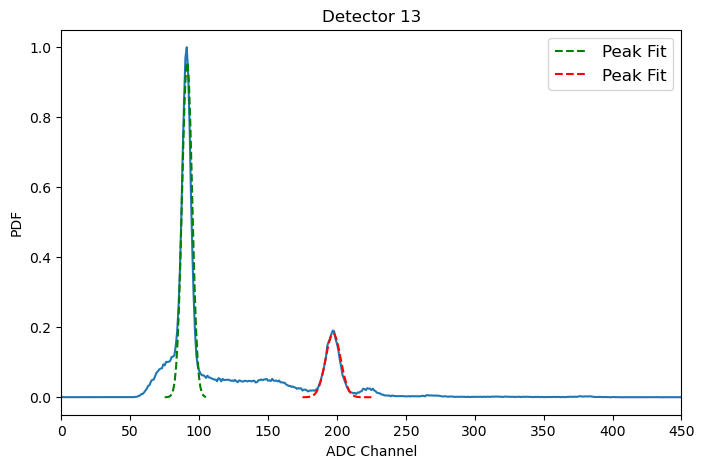

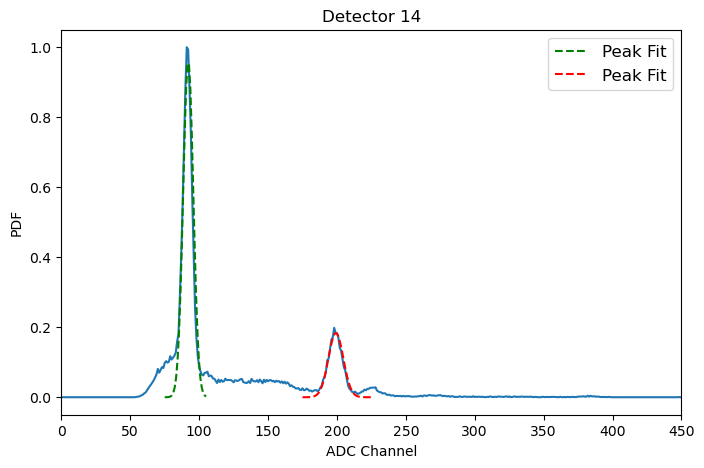

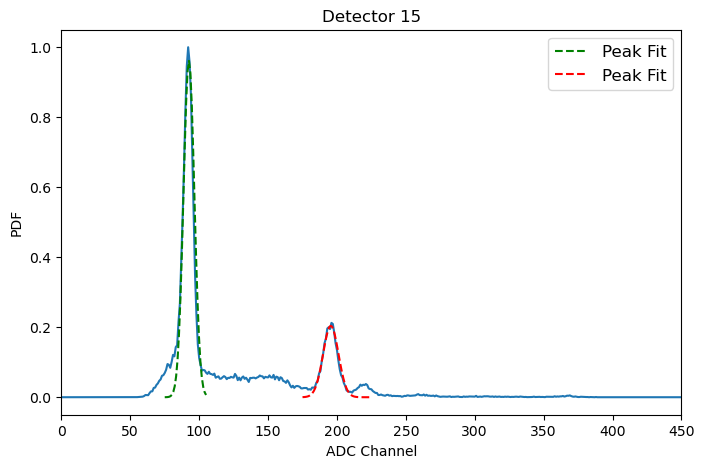

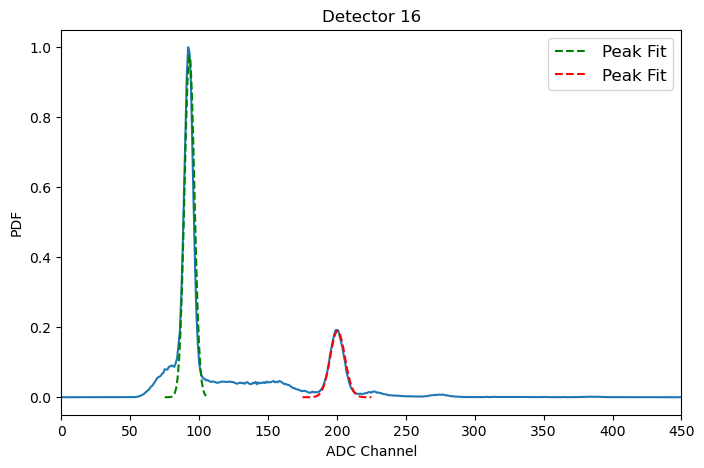

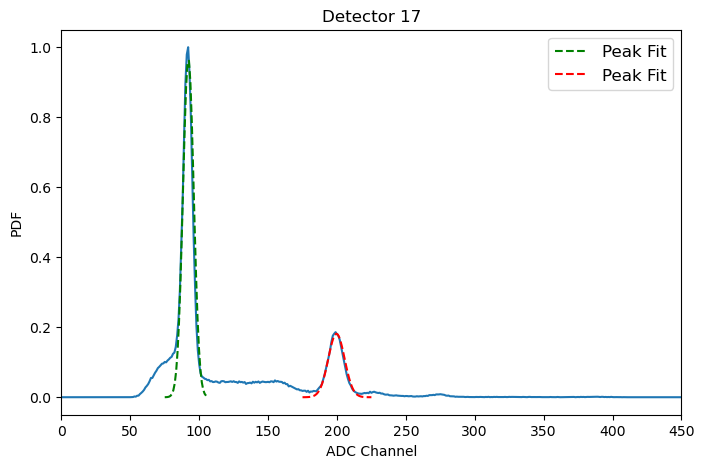

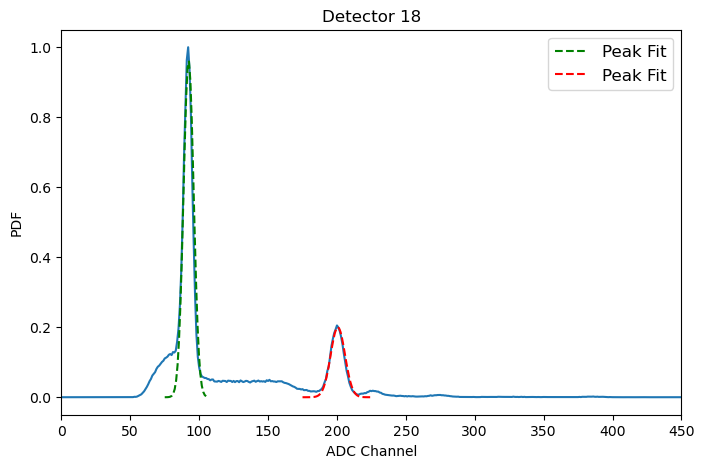

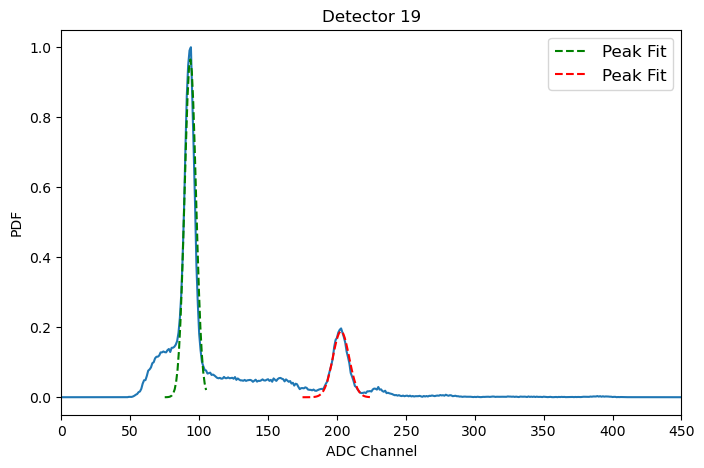

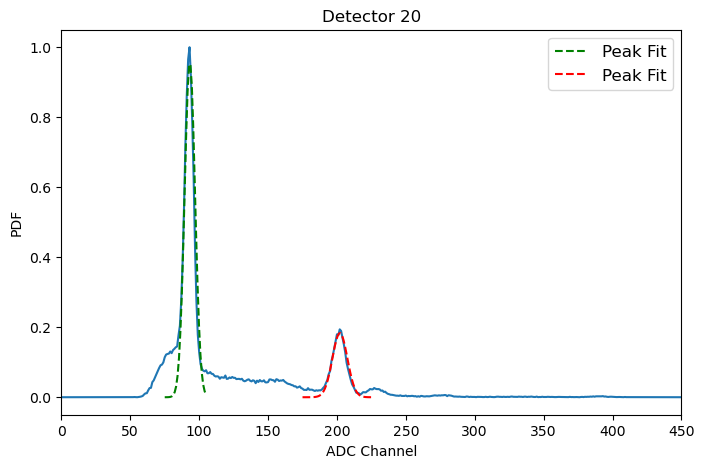

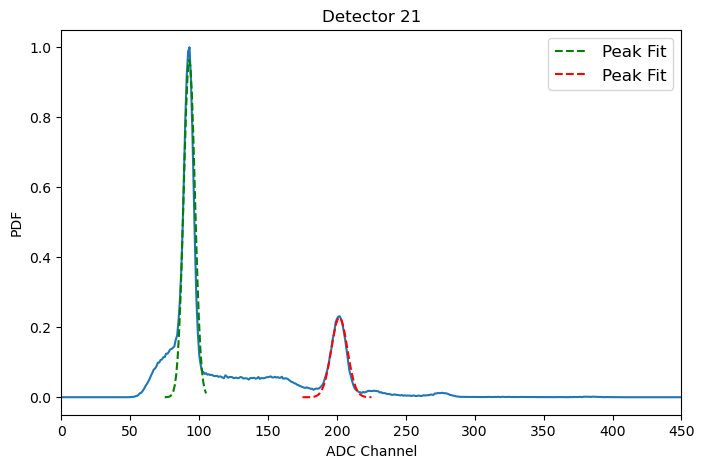

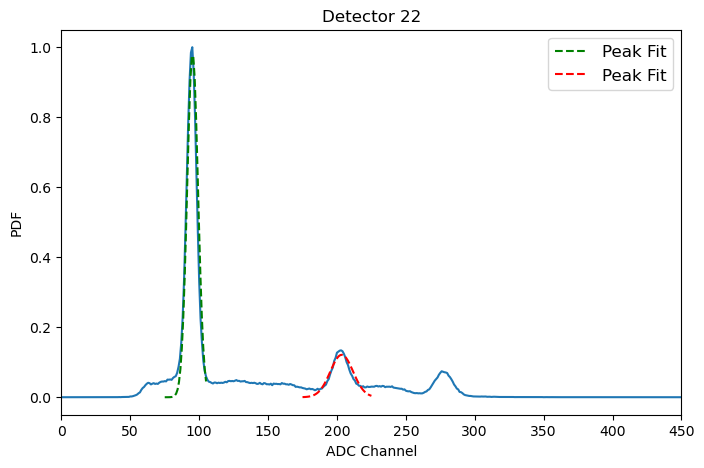

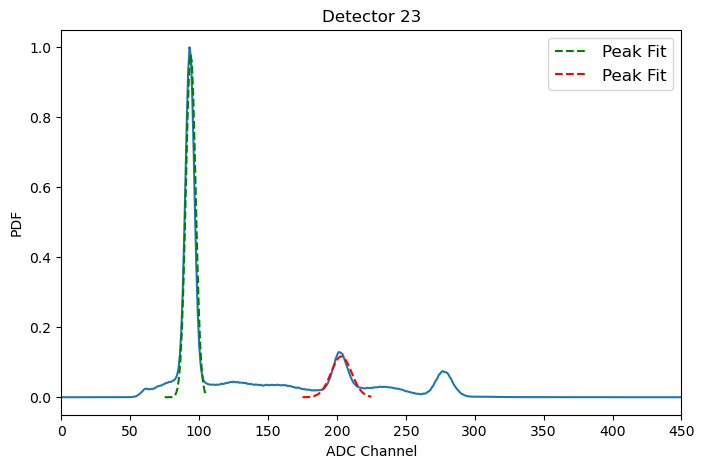

In [6]:
#### Read in data from ROOT files and plot

directory = os.fsencode("Na22_Calibration")
    
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    datafile = "Na22_Calibration/" + filename
    
    with uproot.open(datafile) as file:

        #print(file.keys())
        Na22 = file["Energy/_F_EnergyCH0@DT5751_626"]
        Na22Data,bins = Na22.to_numpy()

        bins = bins[:-1]   # Needed to trim bins to make arrays the same size, not sure why?
        
        Na22Norm = (Na22Data - Na22Data.min())/ (Na22Data.max() - Na22Data.min())   # Normalize since inconsistent counts
        
        #PlotHist(filename,Na22Norm,bins)

        bins1 = np.linspace(75,105,30)
        bins2 = np.linspace(175,225,50)

        popt1, pcov1 = curve_fit(Gauss,bins1,Na22Norm[75:105],p0=[1,92,3])
        popt2, pcov2 = curve_fit(Gauss,bins2,Na22Norm[175:225],p0=[0.2,200,6])

        bestFit1 = Gauss(bins1,popt1[0],popt1[1],popt1[2])
        bestFit2 = Gauss(bins2,popt2[0],popt2[1],popt2[2])

        PlotFit(filename,bins,Na22Norm,bins1,bestFit1,bins2,bestFit2)   # Plot normalized curve with fits
        

In [7]:
#Extra Fitting Code for Manual Fits or More Accurate Lmfit (couldn't quite get working)

        ##################################
        #        MANUAL FITTING
        ##################################

bestFit1 = Gauss(bins1,1,250,6)   # Fit the channel 250 peak
bestFit2 = Gauss(bins2,0.1,415,8)   # Fit the channel 400 peak

        ##################################
        #        LMFIT FITTING
        ################################### 

        # Define function for fitting peaks to a Gaussian distrubution

def FitHist(data,bins,cen,amp,sig,yint,slp):

    peak = GaussianModel()
    background = LinearModel()
    mod = peak + background
        
    #counts, bin_edges = np.histogram(data,bins=bins)
    #bin_widths = np.diff(bin_edges)
    #x = bin_edges[:-1] + (bin_widths/2)
    #y = counts
    x = bins
    y = data
            
    #pars = background.make_params(intercept=yint,slope=slp)
    pars = background.guess(y,x=x,intercept=yint,slope=slp)
    pars += peak.guess(y,x=x,center=cen,amplitude=amp,sigma=sig)
    final_fit = mod.fit(y,pars,x=x)
    #final_fit.plot_fit()
           
    center = final_fit.params['center'].value
    #center_err = final_fit.params['center'].stderr
    width = final_fit.params['fwhm'].value
    #width_err = final_fit.params['fwhm'].stderr
        
    return final_fit   # bins,center,width

# Implement function
    
xval = np.arange(1,len(Na22Data))
print(xval)
    
print(np.shape(Na22Data[75:97]))
print(np.shape(bins1))
print(np.shape(xval[75:97]))
    
fit1 = FitHist(Na22Data[75:107],xval[75:107],90,15000,20,0.3,0.0)
fit2 = FitHist(Na22Data[175:216],xval[175:216],200,2000,25,0.3,0)

print(Na22Data[75:97])
print(bins1)
print(Na22Data[175:216])
print(bins2)

print(fit1.fit_report())
print(fit2.fit_report())

bestFit1 = fit1.best_fit
bestFit2 = fit2.best_fit

bins1 = bins1[:-1]
bins2 = bins2[:-1]

#bestFit1 = fit1.best_fit/np.sum(fit1.best_fit)/np.diff(bins1)[0]
#bestFit2 = fit2.best_fit/np.sum(fit2.best_fit)/np.diff(bins2)[0]


[   1    2    3 ... 4092 4093 4094]
(22,)
(30,)
(22,)
[ 2542.  2699.  2721.  2893.  2871.  2957.  3134.  3253.  3577.  4191.
  5393.  7990. 12441. 19466. 29065. 40674. 51922. 61442. 66025. 64218.
 56543. 46455.]
[ 75.          76.03448276  77.06896552  78.10344828  79.13793103
  80.17241379  81.20689655  82.24137931  83.27586207  84.31034483
  85.34482759  86.37931034  87.4137931   88.44827586  89.48275862
  90.51724138  91.55172414  92.5862069   93.62068966  94.65517241
  95.68965517  96.72413793  97.75862069  98.79310345  99.82758621
 100.86206897 101.89655172 102.93103448 103.96551724 105.        ]
[1530. 1536. 1478. 1439. 1396. 1429. 1297. 1342. 1246. 1336. 1289. 1315.
 1323. 1351. 1379. 1561. 1704. 2061. 2443. 3070. 3667. 4518. 5359. 6171.
 7186. 7840. 8489. 8494. 8319. 8149. 7494. 6702. 5965. 5270. 4476. 3786.
 3227. 2723. 2459. 2166. 1982.]
[175.         176.02040816 177.04081633 178.06122449 179.08163265
 180.10204082 181.12244898 182.14285714 183.16326531 184.18367347
 185.204

[1185.47642245 1304.20272327 1422.92902408 1541.65532489 1660.3816257
 1779.1079265  1897.83422731 2016.56052812 2135.28682892 2254.01312972
 2372.73943053 2491.46573133 2610.19203213 2728.91833293 2847.64463372
 2966.37093452 3085.09723532 3203.82353611 3322.54983691 3441.2761377
 3560.00243849 3678.72873928 3797.45504007 3916.18134086 4034.90764164
 4153.63394243 4272.36024321 4391.086544   4509.81284478 4628.53914556
 4747.26544634 4865.99174712 4984.7180479  5103.44434867 5222.17064945
 5340.89695022 5459.623251   5578.34955177 5697.07585254 5815.80215331
 5934.52845408]
[10901.87500007 11404.92943555 11907.98387103 12411.03830651
 12914.09274198 13417.14717746 13920.20161294 14423.25604842
 14926.3104839  15429.36491938 15932.41935485 16435.47379033
 16938.52822581 17441.58266129 17944.63709677 18447.69153225
 18950.74596772 19453.8004032  19956.85483868 20459.90927416
 20962.96370964 21466.01814512 21969.07258059 22472.12701607
 22975.18145155 23478.23588703 23981.29032251 24484.

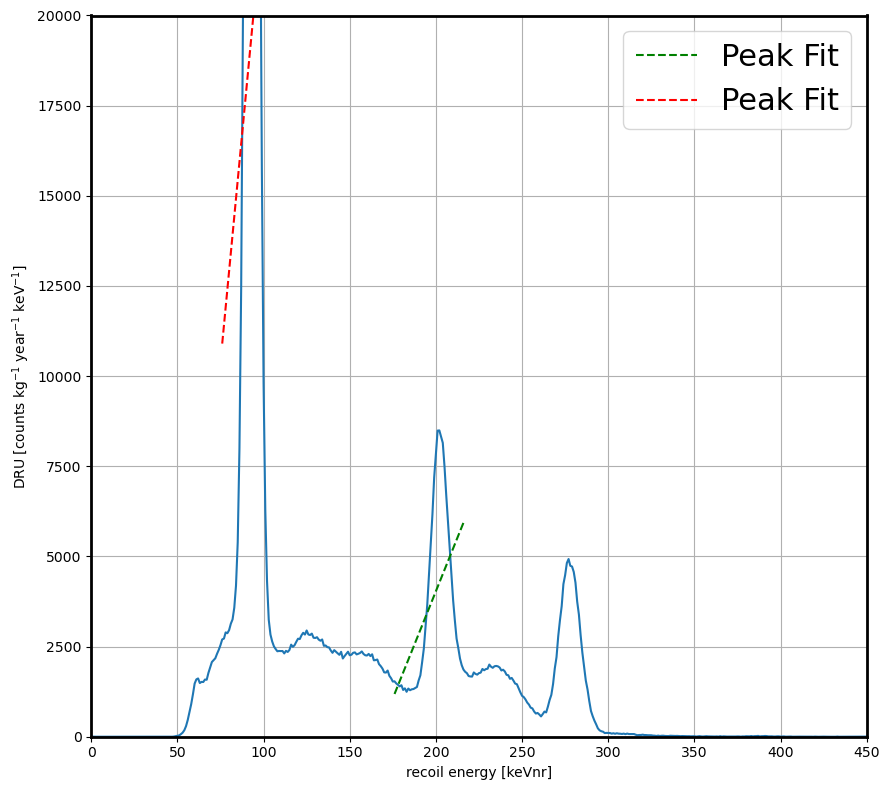

In [8]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


ax1.plot(bins,Na22Data)
ax1.plot(xval[175:216],bestFit2,'g--',label='Peak Fit')
ax1.plot(xval[75:107],bestFit1,'r--',label='Peak Fit')
print(bestFit2)
print(bestFit1)
#ax.plot(bins2,fit2,'r--',label='Peak Fit')




ymin = 0
ymax = 20000

blue = '#118DFA'
#ax1.fill_between(xcq,np.zeros(np.shape(xcq)),thist,step='mid',facecolor='b',alpha=0.4, \
#                 label='')

#ax1.set_yscale('log')
plt.grid()
#ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(0.0, 450) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keVnr]')
ax1.set_ylabel('DRU [counts kg$^{-1}$ year$^{-1}$ keV$^{-1}$]')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('paper_figures/hist.eps')
#plt.savefig('paper_figures/hist.pdf')
plt.show()